In [1]:
from scipy.spatial import distance
import pickle
import torch
from torch import linalg
import numpy as np
from scipy.linalg import cho_solve

/Users/patricktourniaire/opt/miniconda3/envs/nmmm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_object(repo: str, file: str):
    # Path constant to save the object
    PATH = f'{repo}/{file}.pkl'

    with open(PATH, 'rb') as f:
        return pickle.load(f)

In [3]:
features = load_object('../../data/train', 'donut')
features = torch.from_numpy(features)

In [4]:
features

tensor([[ 4.8302,  1.7729],
        [-3.0147,  3.6299],
        [-2.7704, -4.4909],
        ...,
        [ 4.9549, -0.0193],
        [-3.0155, -3.9369],
        [ 5.2306,  0.5260]], dtype=torch.float64)

In [5]:
C = 1000
D = 2

means = torch.zeros(C, D, dtype=torch.float64).normal_(0, 0.5)

mu0 = means[0]
mu1 = means[1]

In [6]:
L = torch.normal(1, 1, size=(C, 1, 1)) * torch.eye(D, D).view(1, D, D)
sigmas = (L).type(torch.float64).contiguous()

S0 = torch.tril(sigmas[0]) @ torch.tril(sigmas[0]).t()
S1 = torch.tril(sigmas[1]) @ torch.tril(sigmas[1]).t()

print(mu0, mu1, S0, S1)

tensor([-0.0905, -0.5913], dtype=torch.float64) tensor([-0.9323, -0.3400], dtype=torch.float64) tensor([[2.1790, 0.0000],
        [0.0000, 2.1790]], dtype=torch.float64) tensor([[2.6286, 0.0000],
        [0.0000, 2.6286]], dtype=torch.float64)


In [7]:
def _sqrd_params(Si, Sj, mui, muj) -> torch.Tensor:
        # Compute the squared Gaussian params
        sigma = torch.inverse(Si + Sj)
        mu = sigma @ (Si @ mui + Sj @ muj)

        return (sigma, mu)

cluster_ids = torch.Tensor(range(C))
cartesian_ids = torch.cartesian_prod(cluster_ids, cluster_ids)
cartesian_ids = cartesian_ids.data.cpu().numpy().astype(int)

recomputed_params = {
    'means': [],
    'sigmas': []
}

for (i, j) in cartesian_ids:
    Si = torch.tril(sigmas[i]) @ torch.tril(sigmas[i]).t()
    Sj = torch.tril(sigmas[j]) @ torch.tril(sigmas[j]).t()
    
    sigma, mean = _sqrd_params(Si, Sj, means[i], means[j])
    
    recomputed_params['sigmas'].append(sigma.data.cpu().numpy())
    recomputed_params['means'].append(mean.data.cpu().numpy())

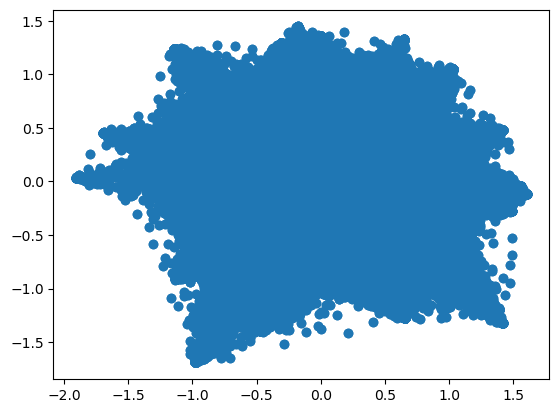

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(np.array(recomputed_params['means'])[:,0], np.array(recomputed_params['means'])[:,1])
plt.show()

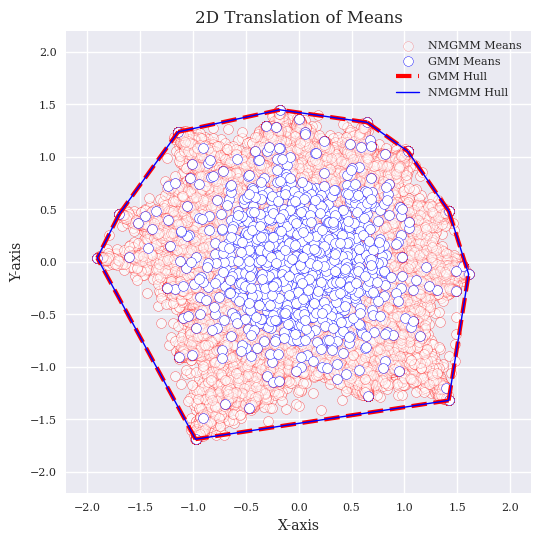

<Figure size 800x550 with 0 Axes>

In [16]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

plt.style.use('seaborn')


tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8
}

plt.rcParams.update(tex_fonts)


hull1 = ConvexHull(means)
hull2 = ConvexHull(np.array(recomputed_params['means']))

fig, ax = plt.subplots(figsize=(6,6))

ax.set_title(r'2D Translation of Means')
ax.set_xlabel(r'X-axis')
ax.set_ylabel(r'Y-axis')

ax.set_xlim(-2.2, 2.2)
ax.set_ylim(-2.2, 2.2)

nmgmm_points = ax.scatter(
                np.array(recomputed_params['means'])[:,0],
                np.array(recomputed_params['means'])[:,1], 
                color='white',
                edgecolors='r',
                alpha=0.4,
                label='NMGMM Means')

gmm_points = ax.scatter(
                means[:,0], 
                means[:,1],
                color='white',
                edgecolors='blue',
                label='GMM Means')

for simplex in hull1.simplices:
    gmm_hull = ax.plot(
        means[simplex, 0],
        means[simplex, 1],
        'r--',
        linewidth=3,
        label='GMM Hull'
    )

for simplex in hull2.simplices:
    nmgmm_hull = ax.plot(
        np.array(recomputed_params['means'])[simplex, 0],
        np.array(recomputed_params['means'])[simplex, 1], 
        'b-',
        linewidth=1,
        label='NMGMM Hull'
    )

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=1)

plt.show()
plt.draw()
fig.savefig('convexhull_mean_translations.png')

In [88]:
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse

def _confidence_ellipse(ax, sigma, mu, n_std=2.3, facecolor='none', **kwargs):
        pearson = sigma[0][1]/np.sqrt(sigma[0][0] * sigma[1][1])
        # Using a special case to obtain the eigenvalues of this
        # two-dimensionl dataset.
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)

        # Calculating the stdandard deviation of x from
        # the squareroot of the variance and multiplying
        # with the given number of standard deviations.
        scale_x = np.sqrt(sigma[0][0]) * n_std
        mean_x = mu[0]

        # calculating the stdandard deviation of y ...
        scale_y = np.sqrt(sigma[1][1]) * n_std
        mean_y = mu[1]

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)

        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

def plot_contours(means, sigmas):
        _, ax = plt.subplots()

        ax.axvline(c='grey', lw=1)
        ax.axhline(c='grey', lw=1)

        for i in range(C):
            sigma = sigmas[i]
            mu = means[i]
            
            config = {
                'alpha': .2
            }

            _confidence_ellipse(ax, sigma, mu, **config)
            ax.scatter(mu[0], mu[1], c='red', s=3)
        
        plt.plot()

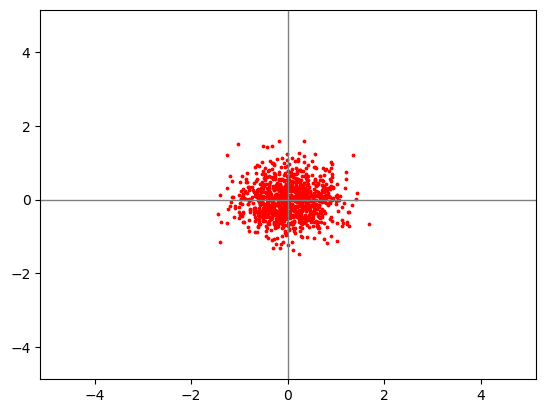

In [89]:
plot_contours(means.data.cpu().numpy(), sigmas.data.cpu().numpy())

In [148]:
sqrd_gen_variance = []

for i in range(C):
    S = recomputed_params['sigmas'][i]
    sqrd_gen_variance.append(np.linalg.det(S))

sqrd_gen_variance = np.array(sqrd_gen_variance)
sqrd_gen_variance

array([7.55983772e+07, 2.77186030e+08, 5.93629658e+07, 7.26464904e+07,
       1.41170172e+08, 1.91484428e+08, 3.32842407e+07, 2.96601119e+08,
       1.15730147e+08, 1.44890997e+08, 6.09464668e+07, 1.93479434e+08,
       1.89557840e+08, 2.19522126e+08, 5.84823654e+07, 1.91075827e+08,
       1.84314418e+08, 2.54337227e+08, 3.02350287e+08, 2.21650637e+08,
       3.82599233e+07, 2.77933454e+08, 9.09728087e+07, 4.78815650e+07,
       2.43116182e+08, 1.53136592e+08, 2.33980811e+08, 2.92615210e+08,
       3.92032803e+07, 1.97868137e+08, 2.10237188e+08, 1.22045966e+08,
       2.99135928e+08, 2.85565893e+08, 1.52061596e+08, 2.26678149e+08,
       1.11797329e+08, 3.01608901e+08, 2.98403215e+08, 2.51616418e+07,
       5.93035457e+07, 2.36047477e+08, 1.71737986e+08, 2.95587170e+08,
       2.74810713e+08, 1.63489922e+08, 2.89661808e+08, 9.68806177e+07,
       1.67749621e+08, 1.66071199e+08, 8.76131532e+07, 1.68891388e+08,
       2.11180255e+08, 2.78139931e+07, 9.98603947e+07, 2.25254491e+08,
      

In [149]:
gen_variance = []

for i in range(C):
    S = torch.tril(sigmas[i]) @ torch.tril(sigmas[i]).t()
    S = S.data.cpu().numpy()
    
    gen_variance.append(np.linalg.det(S))

gen_variance = np.array(gen_variance)
gen_variance

array([3.30694929e-09, 6.54300853e-12, 5.22500702e-09, 3.57837159e-09,
       7.10666994e-10, 2.17851552e-10, 1.34158216e-08, 3.12268045e-13,
       1.25668649e-09, 6.53857189e-10, 4.98252719e-09, 2.06964351e-10,
       2.28799113e-10, 9.97451355e-11, 5.36669357e-09, 2.20137206e-10,
       2.60886822e-10, 2.70180487e-11, 1.68937520e-17, 9.33619270e-11,
       1.08500069e-08, 6.13609155e-12, 2.24089272e-09, 7.57072024e-09,
       4.39385945e-11, 5.43032811e-10, 6.19155757e-11, 9.08099053e-13,
       1.04461438e-08, 1.84538675e-10, 1.31366855e-10, 1.08983273e-09,
       9.75136917e-14, 2.78918955e-12, 5.56403205e-10, 7.94478730e-11,
       1.37423292e-09, 5.58753920e-15, 1.46852391e-13, 2.01215561e-08,
       5.23440914e-09, 5.74841211e-11, 3.53490682e-10, 4.33377146e-13,
       7.93522205e-12, 4.28594279e-10, 1.56302926e-12, 1.94402293e-09,
       3.88214136e-10, 4.03701830e-10, 2.43338575e-09, 3.77980738e-10,
       1.27856651e-10, 1.74522634e-08, 1.81167667e-09, 8.32275911e-11,
      

<BarContainer object of 2 artists>

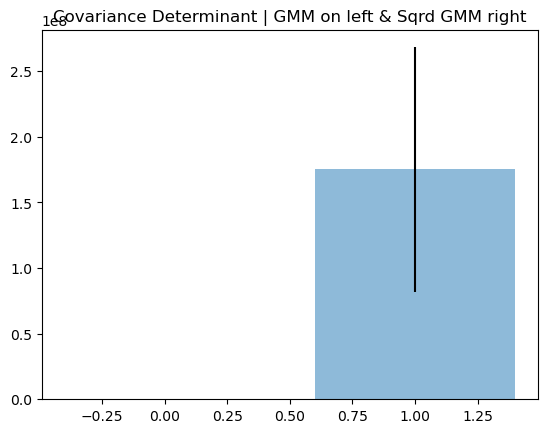

In [150]:
plt.title('Covariance Determinant | GMM on left & Sqrd GMM right')
plt.bar((0, 1), (gen_variance.mean(), sqrd_gen_variance.mean()), yerr=(gen_variance.std(), sqrd_gen_variance.std()), align='center', alpha=0.5)



In [151]:
print(sqrd_gen_variance.mean() - gen_variance.mean())

175144718.68247786


[<matplotlib.patches.Patch object at 0x7fea3c145270>, <matplotlib.patches.Patch object at 0x7fea3c145270>]


<Figure size 640x480 with 0 Axes>

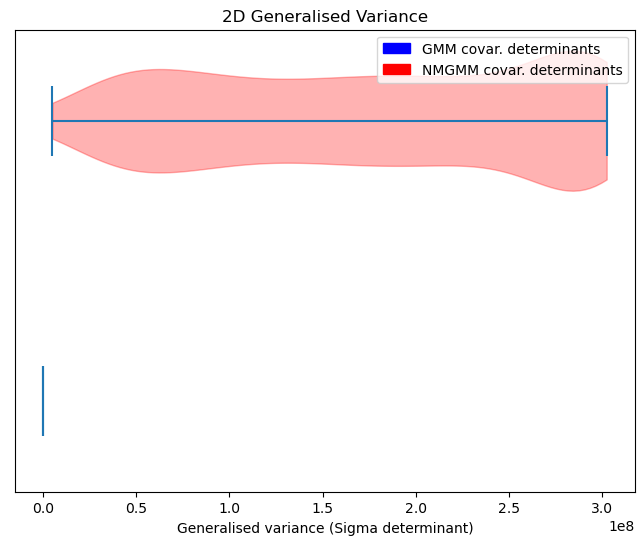

<Figure size 640x480 with 0 Axes>

In [152]:
import matplotlib.patches as mpatches
from itertools import repeat
    
fig = plt.figure()

# Create an axes instance
fig, ax = plt.subplots(figsize=(8,6))
ax.set_yticks([], [])

ax.set_title('2D Generalised Variance')
ax.set_xlabel('Generalised variance (Sigma determinant)')


red_patch = mpatches.Patch(color='red')
# 'fake' invisible object

pos   = [1, 2]
label = ['GMM covar. determinants','NMGMM covar. determinants']

fake_handles = repeat(red_patch, len(pos))
print(list(fake_handles))

# Create the boxplot
violin_parts = ax.violinplot([gen_variance, sqrd_gen_variance], vert=False)
violin_parts['bodies'][1].set_facecolor('red')
violin_parts['bodies'][1].set_edgecolor('red')


ax.legend([mpatches.Patch(color='blue'), mpatches.Patch(color='red')], label)

plt.show()
plt.draw()
fig.savefig('generalised_variance.png')